# Calculate Angles

Calculate dip angles on all ALHIC1901 datasets

## Setup

In [1]:
# Load packages

# general
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

# math
from scipy.stats import pearsonr
import math

# my functions/classes
import sys
sys.path.append("../core_scripts/")
from ECMclass import ECM


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Set filepaths

path_to_data = '../../data/ecm/'
path_to_angles = '../../data/angles/'
path_to_figures = '../../../figures/angles/'

In [3]:
# Set parameters

# smoothing window
window = 1

# spacing of line that we interpolate onto
interp_int = 0.0001

# set angles to cycle through
ang = 45
ang_res = 4 #fraction of angle
test_angle = np.linspace(-ang,ang,2*ang*ang_res+1)

## Load Data

In [4]:
# Load metadata
meta = pd.read_csv(path_to_data + 'metadata.csv')
meta.head()

# for now, trim to just the first three rows
#meta = meta.iloc[5:8]

,core,time,section,face,ACorDC,Y_left,Y_right,AC_edgespace,DC_edgespace
0,alhic1901,cmc1,230_4,t,DC,-5.080,206.763,15,10
1,alhic1901,cmc1,230_4,l,DC,70.404,170.096,15,10
2,alhic1901,cmc1,228_4,t,DC,-10.000,192.000,15,10
3,alhic1901,cmc1,228_4,l,AC,63.881,166.250,15,10
4,alhic1901,cmc1,228_4,l,DC,65.891,149.177,15,10


In [5]:
# Load ECM data

data = []
cores = []
sections = []
faces = []
ACorDCs = []
for index, row in tqdm(meta.iterrows(), total=len(meta), desc="Processing data"):
    
    core = row['core']
        
    section = row['section']
    face = row['face']
    ACorDC = row['ACorDC']

    data_item = ECM(core,section,face,ACorDC)
    print("Reading "+core+", section "+section+'-'+face+'-'+ACorDC)
    
    data_item.rem_ends(15)
    data_item.smooth(window)
    data.append(data_item)
    data_item.norm_all()
    
    cores.append(core)
    sections.append(section)
    faces.append(face)
    ACorDCs.append(ACorDC)




Processing data:   8%|▊         | 1/13 [00:00<00:01,  6.46it/s]

Reading alhic1901, section 230_4-t-DC
Reading alhic1901, section 230_4-l-DC


Processing data:  23%|██▎       | 3/13 [00:00<00:01,  8.78it/s]

Reading alhic1901, section 228_4-t-DC
Reading alhic1901, section 228_4-l-AC


Processing data:  31%|███       | 4/13 [00:00<00:01,  8.16it/s]

Reading alhic1901, section 228_4-l-DC
Reading alhic1901, section 230_4-l-AC


Processing data:  46%|████▌     | 6/13 [00:00<00:00,  8.47it/s]

Reading alhic1901, section 230_4-t-AC


Processing data:  62%|██████▏   | 8/13 [00:01<00:01,  4.70it/s]

Reading alhic1901, section 230_4-r-DC
Reading alhic1901, section 230_4-r-AC


Processing data:  85%|████████▍ | 11/13 [00:01<00:00,  6.71it/s]

Reading alhic1901, section 228_4-r-DC
Reading alhic1901, section 228_4-r-AC
Reading alhic1901, section 228_4-o-AC


Processing data:  92%|█████████▏| 12/13 [00:02<00:00,  5.90it/s]

Reading alhic1901, section 228_4-t-AC


Processing data: 100%|██████████| 13/13 [00:02<00:00,  5.56it/s]


## Preform Angle Calculations

In [6]:
angles = []
scores = []
lengths = []
all_scores = []

# loop through each data file
for data_face in data:

    # print summary
    print("Calculating Angle: "+data_face.core+ 
          ", section "+data_face.section+ '-'+data_face.face+
          '-'+data_face.ACorDC)
    
    

    # make empty depth/angle
    score_list = []
    angle=[]
    angle_depth=[]

    # assign local variables
    depth = data_face.depth_s
    meas = data_face.meas_s
    y_list = data_face.y_s
    y_vec = data_face.y_vec

    # make empty array to score all scores
    all_score = np.zeros((len(test_angle),len(y_vec)-1))

    # flip the depth, meas, and y_list vectors
    depth = np.flip(depth)
    meas = np.flip(meas)
    y_list = np.flip(y_list)

    # make empty list of angle and scores
    angle_list = []
    score_list = []
    length_list = []

    # loop through each pair of adjasent tracks
    for i in range(len(y_vec)-1):

        # get two y_values
        y1 = y_vec[i]
        y2 = y_vec[i+1]
        y_space = abs(y2 - y1)

        # pull out data for both tracks
        idx1 = y_list == y1
        idx2 = y_list == y2
        meas1 = meas[idx1]
        meas2 = meas[idx2]
        depth1 = depth[idx1]
        depth2 = depth[idx2]

        run_score = []

        # loop through each angle
        a_cnt = 0
        for a in test_angle:
            
            # caluclate the spacing between tracks
            yspace = y1-y2

            # calculate the change in depth at this slope
            delta_depth = yspace/1000 * np.tan(a * np.pi/180) * 0.5

            # calculate the new depth vectors
            depth1_shifted = depth1 - delta_depth
            depth2_shifted = depth2 + delta_depth

            # Find the overlapping range between the two depth vectors
            min_overlap = max(min(depth1_shifted), min(depth2_shifted))
            max_overlap = min(max(depth1_shifted), max(depth2_shifted))

            # Round to the nearest 1mm (0.001), rounding min up and max down
            min_overlap_rounded = math.ceil(min_overlap * 1000) / 1000
            max_overlap_rounded = math.floor(max_overlap * 1000) / 1000

            # create new depth vector to interpolate onto
            depth_vec = np.arange(min_overlap_rounded, max_overlap_rounded, interp_int)
            length = max(depth_vec) - min(depth_vec)

            # interpolate the two tracks onto the new depth vector
            meas1_interp = np.interp(depth_vec, depth1_shifted, meas1)
            meas2_interp = np.interp(depth_vec, depth2_shifted, meas2)

            # calculate the correlation
            corr, pval = pearsonr(meas1_interp, meas2_interp)

            # caluclate the score
            run_score.append(corr)

            # save score in 2D array
            all_score[a_cnt,i] = corr
            a_cnt += 1

        # find the best score and angle
        best_score = max(run_score)
        best_angle = test_angle[run_score.index(best_score)]

        # append to the lists
        angle_list.append(best_angle)
        score_list.append(best_score)
        

    # Print rough stats
    print("    Mean Angle = "+str(np.mean(angle_list)))
    print("    Mean Angles = "+str(angle_list))
        
    # save the angles, corrs, and lengths
    angles.append(angle_list)
    scores.append(score_list)
    lengths.append(length_list)      
    all_scores.append(all_score)     

Calculating Angle: alhic1901, section 230_4-t-DC
    Mean Angle = 6.225
    Mean Angles = [37.0, -4.5, -0.25, -0.5, -0.5, 20.75, 29.5, -22.75, 36.0, -8.0, 20.75, -10.25, -0.75, -0.75, 5.0, 10.25, -0.75, 14.75, 0.5, -1.0]
Calculating Angle: alhic1901, section 230_4-l-DC
    Mean Angle = 23.0625
    Mean Angles = [42.25, -43.75, 32.0, 38.75, 29.25, 34.25, 40.75, 11.0]
Calculating Angle: alhic1901, section 228_4-t-DC
    Mean Angle = -9.671052631578947
    Mean Angles = [4.5, -4.5, -14.5, -3.75, -2.25, -39.5, -0.75, -18.0, -34.25, -12.75, -21.25, -14.25, -2.75, -0.75, -17.0, 0.0, -6.25, 0.75, 3.5]
Calculating Angle: alhic1901, section 228_4-l-AC
    Mean Angle = 16.1875
    Mean Angles = [16.0, 14.5, 17.25, 10.0, 13.0, 21.25, 13.0, 24.5]
Calculating Angle: alhic1901, section 228_4-l-DC
    Mean Angle = 1.3214285714285714
    Mean Angles = [5.0, -0.5, 2.5, -1.25, -2.0, 0.25, 5.25]
Calculating Angle: alhic1901, section 230_4-l-AC
    Mean Angle = 30.75
    Mean Angles = [32.25, 29.5, 29.25,

In [7]:
# Save the results

# Set up a df to store the results
face_df = meta.drop(columns=['Y_left', 'Y_right','AC_edgespace','DC_edgespace']).copy()

# save values
face_df['angle'] = angles
face_df['score'] = scores
face_df['length'] = lengths
face_df['all_scores'] = all_scores

# save the dataframe
face_df.head()

,core,time,section,face,ACorDC,angle,score,length,all_scores
0,alhic1901,cmc1,230_4,t,DC,"[37.0, -4.5, -0.25, -0.5, -0.5, 20.75, 29.5, -...","[0.48016485699790146, 0.41878448364644655, 0.4...",[],"[[0.2041754519847349, 0.15131897094994332, 0.0..."
1,alhic1901,cmc1,230_4,l,DC,"[42.25, -43.75, 32.0, 38.75, 29.25, 34.25, 40....","[0.49888416072811836, 0.5751084462646308, 0.77...",[],"[[-0.10894422515214185, 0.5564209898728814, 0...."
2,alhic1901,cmc1,228_4,t,DC,"[4.5, -4.5, -14.5, -3.75, -2.25, -39.5, -0.75,...","[0.8326232142701365, 0.8644111762591575, 0.862...",[],"[[0.7767569962292937, 0.7956265647057323, 0.82..."
3,alhic1901,cmc1,228_4,l,AC,"[16.0, 14.5, 17.25, 10.0, 13.0, 21.25, 13.0, 2...","[0.8938446106987628, 0.9837891610468281, 0.959...",[],"[[0.6847225081944314, 0.8183207411986019, 0.78..."
4,alhic1901,cmc1,228_4,l,DC,"[5.0, -0.5, 2.5, -1.25, -2.0, 0.25, 5.25]","[0.8585566060226771, 0.8679305471183746, 0.845...",[],"[[0.5421824692456041, 0.7106780518997405, 0.59..."


## Diagnostic Plot

Shows the correlation strength as a function of angle for each track. Saves plot, and picks out a couple to show here.

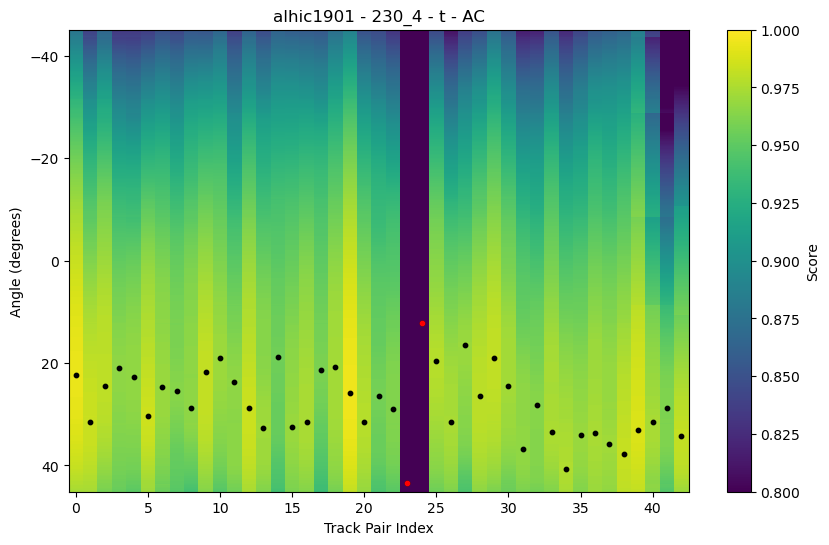

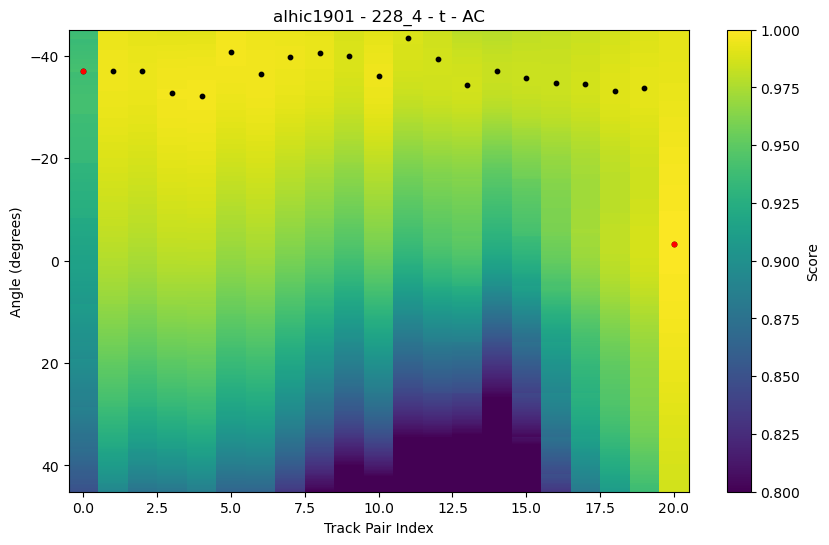

In [8]:
# loop through rows of face_df
for idx, row in face_df.iterrows():

    all_scores = row['all_scores']

    plt.figure(figsize=(10, 6))
    plt.pcolormesh(range(all_scores.shape[1]), test_angle, all_scores, cmap='viridis', shading='auto', norm=plt.Normalize(vmin=0.8, vmax=1))
    plt.colorbar(label='Score')
    plt.title(row['core']+' - '+row['section']+' - '+row['face']+' - '+row['ACorDC'])
    plt.xlabel('Track Pair Index')
    plt.ylabel('Angle (degrees)')
    plt.gca().invert_yaxis()  # Invert y-axis to match the order of test_angle

    # Add black dots at the maximum point in each column
    max_indices = np.argmax(all_scores, axis=0)
    max_scores = all_scores[max_indices, range(all_scores.shape[1])]
    max_angles = test_angle[max_indices]
    mean_angles = np.mean(max_angles)
    std_angles = np.std(max_angles)
    mean_score = np.mean(max_scores)
    std_score = np.std(max_scores)

    mask = (max_scores < mean_score - 2* std_score) | (np.abs(test_angle[max_indices] - mean_angles) > 2*std_angles)

    plt.scatter(range(all_scores.shape[1]), test_angle[max_indices], color='black', s=10, label='Max Points')
    plt.scatter(np.where(mask)[0], test_angle[max_indices[mask]], color='red', s=10, label='High Score Points')

    # Save the figure
    plt.savefig(path_to_figures + 'face_diagnostic/'+ row['core']+'-'+row['section']+'-'+row['face']+'-'+row['ACorDC']+'_angle.png', dpi=300)

    if row['ACorDC'] == 'AC' and row['face'] == 't':
        plt.show()
    else:
        plt.close()

    

## Compute True Angles

In [9]:
def filter(angles,scores):

    # calc mean/std for masking
    mean_scores = np.mean(scores)
    std_scores = np.std(scores)
    mean_angles = np.mean(angles)
    std_angles = np.std(angles)

       # mask the scores
    mask = (scores < mean_scores - 2* std_scores) | (np.abs(angles - mean_angles) > 2*std_angles)

    # mask the angles and scores
    angles = angles[~mask]
    scores = scores[~mask]

    return angles, scores

In [10]:
def calc_weighted_mean_face(face_df,face,section):
    # function to calculate the weighted mean angle for a given face and section

    # filter the dataframe
    df = face_df[(face_df['section'] == section) & 
                    (face_df['ACorDC'] == 'AC') & 
                    (face_df['face'] == face)]

    # pull out scores and angles
    scores = np.array(df.score.to_list())[0]
    angles = np.array(df.angle.to_list())[0]

    angles, scores = filter(angles,scores)

    # compute weighted average
    weighted_ave = np.sum(angles * scores)/ np.sum(scores)

    return weighted_ave
    

In [11]:


def calc_true_dip(face_df,section):
    # function to calculate the true dip for a given section

    # filter the dataframe
    df = face_df[(face_df['section'] == section) & 
                    (face_df['ACorDC'] == 'AC')]

    top_scores = np.array(df[df['face'] == 't'].score.values[0])
    left_scores = np.array(df[df['face'] == 'l'].score.values[0])
    right_scores = np.array(df[df['face'] == 'r'].score.values[0])
    side_scores = np.concatenate((left_scores, right_scores))

    top_angles = np.array(df[df['face'] == 't'].angle.values[0])
    left_angles = np.array(df[df['face'] == 'l'].angle.values[0])
    right_angles = np.array(df[df['face'] == 'r'].angle.values[0]) * -1
    side_angles = np.concatenate((left_angles, right_angles))

    # filter out the bad values
    top_angles, top_scores = filter(top_angles,top_scores)
    side_angles, side_scores = filter(side_angles,side_scores)

    true_angles = []
    true_scores = []
    for top_a,top_s in zip(top_angles,top_scores):
        for side_a,side_s in zip(side_angles,side_scores):
            
            # compute the true dip
            alpha = np.arctan(np.tan(side_a * np.pi/180) / np.tan(top_a * np.pi/180))
            true_angles.append(np.arctan(np.tan(top_a * np.pi/180)/np.cos(alpha)))
            true_scores.append(top_s * side_s) 

    return np.array(true_angles), np.array(true_scores)

a,s = calc_true_dip(face_df,'228_4')

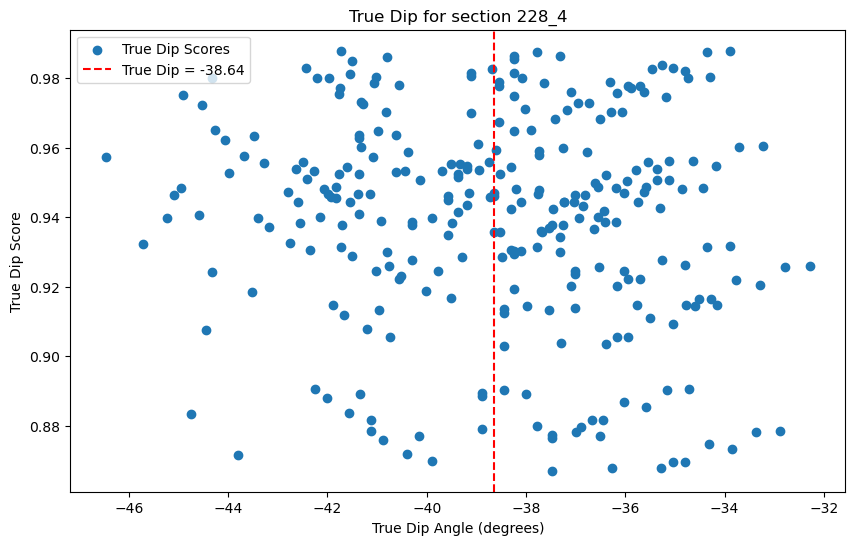

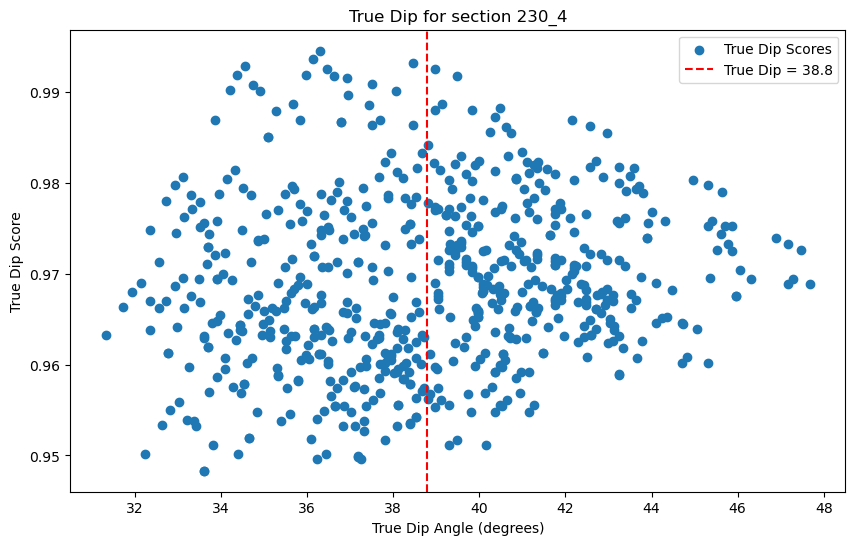

,core,section,ACorDC,top_angle,left_angle,right_angle,side_angle,true_dip,true_dip_angles,true_dip_scores
0,alhic1901,228_4,AC,-36.776051,16.199769,-10.606322,-13.403045,-38.643013,"[-38.87808981361987, -38.54424141855013, -39.1...","[0.8893320524495956, 0.9788225193722169, 0.954..."
1,alhic1901,230_4,AC,27.819776,30.749623,-30.156336,-30.452979,38.799076,"[36.942420009648416, 34.922393415315945, 34.74...","[0.9915091458982633, 0.9900504183547936, 0.990..."


In [ ]:
angles_df = pd.DataFrame()

wt_t = 0
wt_l = 0
wt_r = 0

# loop through each section
for section in ['228_4','230_4']:

    for face, weighted_ave in zip(['t','l','r'],[wt_t,wt_l,wt_r]):

        # compute weighted mean on each face
        wt_t = calc_weighted_mean_face(face_df,'t',section)
        wt_l = calc_weighted_mean_face(face_df,'l',section)
        wt_r = calc_weighted_mean_face(face_df,'r',section)  
        wt_side = (wt_l - wt_r)/2

    a,s = calc_true_dip(face_df,section)

    true_dip = np.sum(a * s) /np.sum(s)

    plt.figure(figsize=(10, 6))
    plt.scatter(a*180/np.pi, s, label='True Dip Scores')
    plt.axvline(x=true_dip*180/np.pi, color='red', linestyle='--', label='True Dip = '+str(round(true_dip*180/np.pi,2)))
    plt.xlabel('True Dip Angle (degrees)')
    plt.ylabel('True Dip Score')
    plt.title('True Dip for section ' + section)
    plt.legend()
    plt.savefig(path_to_figures + section+'_true_dip.png', dpi=300)
    plt.show()

    # save the results
    angles_df = pd.concat([angles_df, pd.DataFrame({
        'core': ['alhic1901'],
        'section': [section],
        'ACorDC': [ACorDC],
        'top_angle': [wt_t],
        'left_angle': [wt_l],
        'right_angle': [wt_r],
        'side_angle': [wt_side],
        'true_dip': [true_dip*180/np.pi],
        'true_dip_angles': [a*180/np.pi],
        'true_dip_scores': [s],
    })], ignore_index=True)
            
# save the angles_df
angles_df.to_csv(path_to_angles + 'angles.csv', index=False)
angles_df.head()